### **Papua Wildfire Prediction** by Haritsyam Anshari

---

On this notebook, a wildfire prediction on Papua is done with dataset acquired from Google Earth Engine. There's 3 features which is:

1. Precipitation Band from UCSB-CHG_CHIRPS_DAILY
2. NDVI Band from MODIS/061/MOD13Q1
3. LST Band from MODIS/061/MOD11A1
4. Longitude and Latitude
5. Altitude from USGS/SRTMGL1_003
6. Soil Organic Carbon from OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02

Note: I was trying to represent peatland with Soil Organic Carbon data, but It's highly unlikely that the both correlates to each other. Later, you'll see me dropping that particular feature.

The label is:

1.   T21 Band from FIRMS

Data collection summary:
We used the points from FIRMS or "fire points" as a point reference. Then, we'll try to find all the features based on that location and time provided by the "fire points". Finally, we'll have a dataset of all "1" labels or wildfire spots.

After that, we'll generate many random points and find all the correlating features too. This is to generate the dataset of all "0" labels. Both "1" and "0" will have to be balanced.








---

In this part, the ee library is imported, authenticated, and initialized.

Then, geojson.io is used to acquire Papua's coordinates. The Papua region of interest is based on this polygon.

In [ ]:
# Importing the Earth Engine and others
import ee
import geemap.core as geemap
import pandas as pd


# The values acquired from the dataset is not scaled,
# We define a function to scale the values.
def scale_ndvi(image):
    return image.multiply(0.0001).copyProperties(image, ["system:time_start"])

def scale_lst(image):
    return (
        image.multiply(0.02)
        .subtract(273.15)
        .copyProperties(image, ["system:time_start"])
    )

In [ ]:
# We'll have to create a project in the Google Cloud Earth Engine
ee.Authenticate()
ee.Initialize(project="wildfire-prediction-indonesia")

# Papua coordinates acquired freom geojson.io
papua_coordinates = [
    [
        [141.0103507212075, -2.354117055169766],
        [135.83657920690644, -0.45950257272586725],
        [132.55320406843703, -0.3072350613381758],
        [130.19711880945067, 0.3179938449721931],
        [129.7982511309582, -0.4283299633980704],
        [129.6148807480468, -1.2455648321386832],
        [129.60444606522242, -2.3080779387546926],
        [132.84359885395742, -4.1785176939227995],
        [137.657234642869, -6.363617108941185],
        [137.45979553761794, -8.77718810356555],
        [141.02665830273742, -9.380791791124679],
        [141.0103507212075, -2.354117055169766],
    ]
]

# Papua region of interest based on the Papua coordinates
papua_roi = ee.Geometry.Polygon(papua_coordinates)

# Precipitation from CHIRPS
chirps_daily_dataset = (
    ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
    .filter(ee.Filter.date("2020-01-01", "2025-01-01"))
    .filterBounds(papua_roi)
)

precipitation = chirps_daily_dataset.select("precipitation")

# NDVI from MOD13Q1
ndvi_dataset = (
    ee.ImageCollection("MODIS/061/MOD13Q1")
    .filter(ee.Filter.date("2020-01-01", "2025-01-01"))
    .filterBounds(papua_roi)
)

ndvi = ndvi_dataset.select("NDVI").map(scale_ndvi)

# LST from MOD11A1
lst_dataset = (
    ee.ImageCollection("MODIS/061/MOD11A1")
    .filter(ee.Filter.date("2020-01-01", "2025-01-01"))
    .filterBounds(papua_roi)
)

lst = lst_dataset.select("LST_Day_1km").map(scale_lst)

# Altitude from SRTM
altitude_dataset = (
    ee.Image("USGS/SRTMGL1_003")
    .clip(papua_roi)
)

altitude = altitude_dataset.select("elevation")

# Peatland
peatland_dataset = (
    ee.Image("OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02")
    .clip(papua_roi)
)

peatland = peatland_dataset.select("b0")

# T21 from FIRMS
firms_dataset = (
    ee.ImageCollection("FIRMS")
    .filter(ee.Filter.date("2020-01-01", "2025-01-01"))
    .filterBounds(papua_roi)
)

t21 = firms_dataset.select("T21")


---

In this part, we simply try to visualize the variable we have extracted.

We use the mean and max to reduce the dimension of the image collection to a single image. Simply for human exploration.

Note: There's an awkward colormap used in some of the variables, you might want to look into that.

In [ ]:
m = geemap.Map()
m.centerObject(papua_roi, 6)

# Precipitation (rain) mean visualization
rain_mean = precipitation.mean().clip(papua_roi)
m.add_layer(
    rain_mean,
    {"min": 0, "max": 15, "palette": ["white", "blue", "darkblue"]},
    "Rata-rata Hujan",
)

# LST (land surface temperature) mean in celcius visualization
lst_mean = lst.mean().clip(papua_roi)
m.add_layer(
    lst_mean,
    {"min": 20, "max": 35, "palette": ["green", "yellow", "red"]},
    "Rata-rata Suhu (C)",
)

# NDVI (vegetation) mean visualization
ndvi_mean = ndvi.mean().clip(papua_roi)
m.add_layer(
    ndvi_mean,
    {"min": 0, "max": 0.8, "palette": ["brown", "lightgreen", "darkgreen"]},
    "Vegetasi (NDVI)",
)

# Altitude
altitude = altitude.clip(papua_roi)
m.add_layer(
    altitude,
    {"min": 0, "max": 5000, "palette": ["green", "yellow", "red"]},
    "Altitude (m)",
)

# Peatland / Soil Carbon
peatland = peatland.clip(papua_roi)
m.add_layer(
    peatland,
    {"min": 0, "max": 120, "palette": ["brown", "lightgreen", "darkgreen"]},
    "Peatland b0",
)

# Fire hotspot max visualization
fire_max = t21.max().clip(papua_roi)
m.add_layer(
    fire_max,
    {"min": 300, "max": 400, "palette": ["yellow", "red"]},
    "Titik Api (Max Temp)",
)

m


Map(center=[-3.7979532881370277, 136.3452141838204], controls=(ZoomControl(options=['position', 'zoom_in_text'…

---

Next, we define a function to extract features based on the location of fire hotspots.

In each variable, we would:

1.   Filter by date, to calculate sum or mean on that range
2.   Select our features/bands
3.   Sum or mean those values filtered by the date range
4.   Acquire the feature value based on the fire hotspot points with reduceRegion and get.

Notes:

*   Basically, when we filter by date, we would get a collection of images, a temporal images, I would say. Then, we would calculate with mean, sum, or first, to get a single image with a single value. Finally, with the known fire hotspot "points" we could extract the feature values on that particular point, with reduceRegion and get.






In [ ]:
def extract_temporal_data(feature, target_label):
    fire_date = ee.Date(feature.get("system:time_start"))

    # Precipitation or rain
    start_date_rain = fire_date.advance(-7, "day")
    rain_col = chirps_daily_dataset.filterDate(start_date_rain, fire_date).select("precipitation")

    # Safety check: Are the rain images on that particular date available?
    rain_img = ee.Image(ee.Algorithms.If(
        rain_col.size().gt(0),
        rain_col.sum().unmask(-9999),
        ee.Image.constant(-9999).rename("precipitation")
    ))

    total_rain = rain_img.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=feature.geometry(),
            scale=5000,
        ).get("precipitation")

    total_rain = ee.Algorithms.If(ee.Number(total_rain).eq(-9999), None, total_rain)


    # LST
    start_date_lst = fire_date.advance(-1, "day")
    end_date_lst = fire_date.advance(1, "day")

    lst_col = lst_dataset.filterDate(start_date_lst, end_date_lst).select("LST_Day_1km")

    # Safety check
    lst_img = ee.Image(ee.Algorithms.If(
        lst_col.size().gt(0),
        lst_col.map(scale_lst).mean().unmask(-9999),
        ee.Image.constant(-9999).rename("LST_Day_1km")
    ))

    recent_lst = lst_img.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=feature.geometry(),
            scale=1000,
        ).get("LST_Day_1km")

    # Change -9999 to None
    recent_lst = ee.Algorithms.If(ee.Number(recent_lst).eq(-9999), None, recent_lst)


    # NDVI
    # 30 Day range for vegetation
    ndvi_col = ndvi_dataset.filterDate(fire_date.advance(-30, "day"), fire_date).select("NDVI")

    # Safety check
    ndvi_img = ee.Image(ee.Algorithms.If(
        ndvi_col.size().gt(0),
        ndvi_col.map(scale_ndvi).mean().unmask(-9999),
        ee.Image.constant(-9999).rename("NDVI")
    ))

    recent_ndvi = ndvi_img.reduceRegion(
            reducer=ee.Reducer.first(),
            geometry=feature.geometry(),
            scale=1000
        ).get("NDVI")

    # Change -9999 to None
    recent_ndvi = ee.Algorithms.If(ee.Number(recent_ndvi).eq(-9999), None, recent_ndvi)

    # Longitude and Latitude
    coordinates = feature.geometry().coordinates()
    longitude = coordinates.get(0)
    latitude = coordinates.get(1)

    # Altitude
    altitude_img = altitude_dataset.select("elevation")
    altitude_val = altitude_img.unmask(-9999).reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=feature.geometry(),
        scale=30
    ).get("elevation")

    altitude_val = ee.Algorithms.If(ee.Number(altitude_val).eq(-9999), None, altitude_val)

    # Soil Organic Carbon (trying to find the "peatland feature", well we'll try)
    peatland_img = peatland_dataset.select("b0")
    peatland_val = peatland_img.unmask(-9999).reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=feature.geometry(),
        scale=250
    ).get("b0")

    peatland_val = ee.Algorithms.If(ee.Number(peatland_val).eq(-9999), None, peatland_val)

    # Return
    return feature.set(
        {
            "rain_7d_sum": total_rain,
            "lst_temp": recent_lst,
            "ndvi_val": recent_ndvi,

            "latitude": latitude,
            "longitude": longitude,
            "altitude": altitude_val,
            "peatland": peatland_val,

            "fire_temp": feature.get("first"),
            "date_str": fire_date.format("YYYY-MM-dd"),
            "label": target_label,
        }
    )


---



In [ ]:
# In this part, we'll find the features using extract_temporal_data function for "fire points"
fire_points_raw = firms_dataset.select('T21') \
    .filterDate('2020-01-01', '2025-01-01') \
    .map(lambda img: img.toInt().addBands(img).reduceToVectors(
        geometry=papua_roi,
        scale=1000,
        geometryType='centroid',
        labelProperty='zone_id',    # Dummy ID Integer
        reducer=ee.Reducer.first(), # Taking the real T21 float value from the second band
        bestEffort=True
    ).map(lambda f: f.set('system:time_start', img.get('system:time_start')))) \
    .flatten()

# Temporal extraction
dataset_with_weather = fire_points_raw.map(lambda feature: extract_temporal_data(feature, target_label=1))

# Remove null values, for example, image hindered by clouds
dataset_clean = dataset_with_weather.filter(ee.Filter.notNull(['lst_temp', 'ndvi_val', 'rain_7d_sum', 'peatland']))

In [ ]:
# import pandas as pd


# Feature collection to Pandas dataframe
# def fc_to_df(feature_collection):
    # Retrieve data from Google server to Python with JSON format
    # data_json = feature_collection.getInfo()

    # Take "properties" from every feature
    # features = [feat["properties"] for feat in data_json["features"]]

    # Input to Pandas
    # return pd.DataFrame(features)


# df_temporal = fc_to_df(dataset_clean)
# print(df_temporal.head())

In [ ]:
import time

final_columns = ['date_str', 'fire_temp', 'first', 'label', 'lst_temp', 'ndvi_val', 'rain_7d_sum', 'longitude', 'latitude', 'altitude', 'peatland', 'system:time_start', 'zone_id']

task = ee.batch.Export.table.toDrive(
    collection=dataset_clean,
    description='temporal_fire',
    folder='EarthEngineData',
    fileNamePrefix='temporal_fire',
    fileFormat='CSV',
    selectors=final_columns
)

task.start()
print("Export starts...")

while task.active():
    print("Status: ", task.status()['state'])
    time.sleep(30)

print("Done with export.")

Export starts...
Status:  READY
Status:  RUNNING
Status:  RUNNING
Status:  RUNNING
Done with export.


In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

df_fire_final = pd.read_csv('/content/drive/MyDrive/EarthEngineData/temporal_fire.csv')
print(df_fire_final.head())
df_fire_final.describe()

Mounted at /content/drive
     date_str   fire_temp       first  label  lst_temp  ndvi_val  rain_7d_sum  \
0  2020-01-11  315.899994  315.899994      1     30.71    0.8669    65.134527   
1  2020-01-11  313.100006  313.100006      1     28.63    0.9054    65.134527   
2  2020-01-15  302.200012  302.200012      1     20.73    0.6359    57.847635   
3  2020-01-15  303.500000  303.500000      1     23.25    0.7563    43.267481   
4  2020-01-15  302.200012  302.200012      1     18.19    0.7032    50.273962   

    longitude  latitude  altitude  peatland  system:time_start  zone_id  
0  133.239164 -0.853863       567         7      1578700800000      315  
1  133.253127 -0.867353       735         9      1578700800000      313  
2  138.747894 -3.979002      2436        11      1579046400000      302  
3  138.990680 -4.028465      2094         9      1579046400000      303  
4  139.356450 -4.311751      2957        17      1579046400000      302  


,fire_temp,first,label,lst_temp,ndvi_val,rain_7d_sum,longitude,latitude,altitude,peatland,system:time_start,zone_id
count,5480.000000,5480.000000,5480.0,5480.000000,5480.000000,5480.000000,5480.000000,5480.000000,5480.000000,5480.000000,5.480000e+03,5480.000000
mean,321.734361,321.734361,1.0,30.772936,0.642959,14.956637,139.212940,-7.050544,183.536861,18.243796,1.674332e+12,321.247628
std,11.608695,11.608695,0.0,4.633859,0.115679,21.948883,1.740979,2.054579,522.042734,11.340652,4.191287e+10,11.612775
min,300.200012,300.200012,1.0,7.790000,0.158600,0.000000,131.260904,-9.087143,-1.000000,2.000000,1.578701e+12,300.000000
25%,314.465004,314.465004,1.0,28.010000,0.567400,0.000000,138.701712,-8.227449,7.000000,11.000000,1.647518e+12,314.000000
50%,319.540009,319.540009,1.0,30.670000,0.644975,6.830021,139.393490,-7.884302,13.000000,15.000000,1.693613e+12,319.000000
75%,326.200012,326.200012,1.0,33.472500,0.721812,19.696452,140.497687,-7.327847,23.000000,21.000000,1.698278e+12,326.000000
max,448.859985,448.859985,1.0,48.770000,0.923700,250.769161,141.023471,-0.471652,3309.000000,96.000000,1.733962e+12,448.000000


In [ ]:
import time
import pandas as pd
from google.colab import drive

# Mount drive
drive.mount('/content/drive')

# Length of fire points in the all "1" labels dataset
length_points = len(df_fire_final)
# We're generating much more than the specified length just in case
points_to_generate = length_points * 5

print(f"Lenght of fire points: {length_points} points.")
print(f"Points we generate: {points_to_generate} points (for anticipating cloud and sea).")

# Generate points
non_fire_raw = ee.FeatureCollection.randomPoints(
    region=papua_roi,
    points=points_to_generate,
    seed=24
)

# Set Random Date & Dummy Properties
def set_random_properties(feature):
    start_millis = ee.Date("2020-01-01").millis()
    end_millis = ee.Date("2025-01-01").millis()
    diff = end_millis.subtract(start_millis)

    # Parsing ID for random seed
    id_num = ee.Number.parse(feature.id())
    rand_ratio = id_num.sin().multiply(100000).mod(1).abs()
    random_date = start_millis.add(diff.multiply(rand_ratio))

    return feature.set({
        "system:time_start": random_date,
        "label": 0,
        "first": 0,    # Dummy value agar kolom sama dengan data Fire
        "T21": 0,      # Dummy value
        "fire_temp": 0 # Dummy value
    })

# Execute pipeline
non_fire_ready = non_fire_raw.map(set_random_properties)

# Called extract_temporal_data function
dataset_non_fire = non_fire_ready.map(lambda feature: extract_temporal_data(feature, target_label=0))

# Filtering, so that we don't take points generated in cloud, sea, or null values
dataset_non_fire_clean = dataset_non_fire.filter(
    ee.Filter.notNull(["lst_temp", "ndvi_val", "rain_7d_sum", "peatland"])
)

# We'll limit so it would be a balanced between "0" and "1"
dataset_non_fire_final = dataset_non_fire_clean.limit(length_points)

# 8. Exporting to drive
final_columns_nonfire = ['date_str', 'fire_temp', 'first', 'label', 'lst_temp', 'ndvi_val', 'rain_7d_sum', 'longitude', 'latitude', 'altitude', 'peatland', 'system:time_start']

task = ee.batch.Export.table.toDrive(
    collection=dataset_non_fire_final,
    description='temporal_nonfire_export',
    folder='EarthEngineData',
    fileNamePrefix='temporal_nonfire',
    fileFormat='CSV',
    selectors=final_columns_nonfire
)

task.start()
print("Export task started within Google Earth Engine servers...")

# Status monitoring
while task.active():
    print(f"Status: {task.status()['state']} (Waiting for GEE...)")
    time.sleep(30)

print("GEE Task Completed")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Lenght of fire points: 5480 points.
Points we generate: 27400 points (for anticipating cloud and sea).
Export task started within Google Earth Engine servers...
Status: READY (Waiting for GEE...)
Status: RUNNING (Waiting for GEE...)
Status: RUNNING (Waiting for GEE...)
Status: RUNNING (Waiting for GEE...)
Status: RUNNING (Waiting for GEE...)
Status: RUNNING (Waiting for GEE...)
Status: RUNNING (Waiting for GEE...)
Status: RUNNING (Waiting for GEE...)
GEE Task Completed


In [ ]:
# Read safely
csv_path = '/content/drive/MyDrive/EarthEngineData/temporal_nonfire.csv'

max_retries = 10
for i in range(max_retries):
    try:
        df_nonfire_final = pd.read_csv(csv_path)
        print("Done!")
        break
    except FileNotFoundError:
        print(f"File isn't found (Attempt# {i+1}/{max_retries})")
        time.sleep(30)
else:
    print("Failed to read. Check the drive manually!")

# 11. Cek Hasil
if 'df_nonfire_final' in locals():
    print(f"Target Length: {length_points}")
    print(f"Actual Length: {len(df_nonfire_final)}")
    print(df_nonfire_final.head())
    print(df_nonfire_final.describe())

Done!
Target Length: 5480
Actual Length: 3500
     date_str  fire_temp  first  label  lst_temp  ndvi_val  rain_7d_sum  \
0  2023-09-18          0      0      0     23.73   0.54890    28.613520   
1  2020-01-02          0      0      0     32.17   0.79160    11.862969   
2  2024-02-15          0      0      0     19.67   0.68335     0.260247   
3  2020-02-07          0      0      0     26.41   0.84980    68.721939   
4  2021-08-28          0      0      0     25.71   0.80480    24.187008   

    longitude  latitude  altitude  peatland  system:time_start  
0  133.220734 -1.349026       685         8       1.695071e+12  
1  133.854547 -2.026248        40         9       1.577964e+12  
2  133.758229 -1.428550      2425        18       1.708012e+12  
3  136.799500 -2.789044       446         7       1.581097e+12  
4  140.203676 -3.246524       211        13       1.630191e+12  
       fire_temp   first   label     lst_temp     ndvi_val  rain_7d_sum  \
count     3500.0  3500.0  3500.0  3500

In [ ]:
frames = [df_fire_final, df_nonfire_final]
df_final = pd.concat(frames)

df_final.drop(['fire_temp', 'zone_id', 'first', 'date_str', 'system:time_start'], axis = 1, inplace = True)
print(df_final.head())
df_final.info()
df_final.describe()

   label  lst_temp  ndvi_val  rain_7d_sum   longitude  latitude  altitude  \
0      1     30.71    0.8669    65.134527  133.239164 -0.853863       567   
1      1     28.63    0.9054    65.134527  133.253127 -0.867353       735   
2      1     20.73    0.6359    57.847635  138.747894 -3.979002      2436   
3      1     23.25    0.7563    43.267481  138.990680 -4.028465      2094   
4      1     18.19    0.7032    50.273962  139.356450 -4.311751      2957   

   peatland  
0         7  
1         9  
2        11  
3         9  
4        17  
<class 'pandas.core.frame.DataFrame'>
Index: 8980 entries, 0 to 3499
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   label        8980 non-null   int64  
 1   lst_temp     8980 non-null   float64
 2   ndvi_val     8980 non-null   float64
 3   rain_7d_sum  8980 non-null   float64
 4   longitude    8980 non-null   float64
 5   latitude     8980 non-null   float64
 6   altitude   

,label,lst_temp,ndvi_val,rain_7d_sum,longitude,latitude,altitude,peatland
count,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000,8980.000000
mean,0.610245,28.493481,0.683173,31.992527,138.375221,-5.753311,344.398998,17.813808
std,0.487722,5.475540,0.132044,38.653291,2.487029,2.586973,718.833039,11.787841
min,0.000000,2.890000,0.122200,0.000000,129.740128,-9.087143,-1.000000,2.000000
25%,0.000000,25.737500,0.594300,4.391863,137.830816,-8.039434,9.000000,11.000000
50%,1.000000,28.550000,0.687375,18.257624,139.007731,-7.150956,21.000000,14.000000
75%,1.000000,31.710000,0.788125,48.318665,140.248891,-3.566106,216.000000,20.000000
max,1.000000,48.770000,0.943900,379.538532,141.023471,-0.010890,4508.000000,119.000000


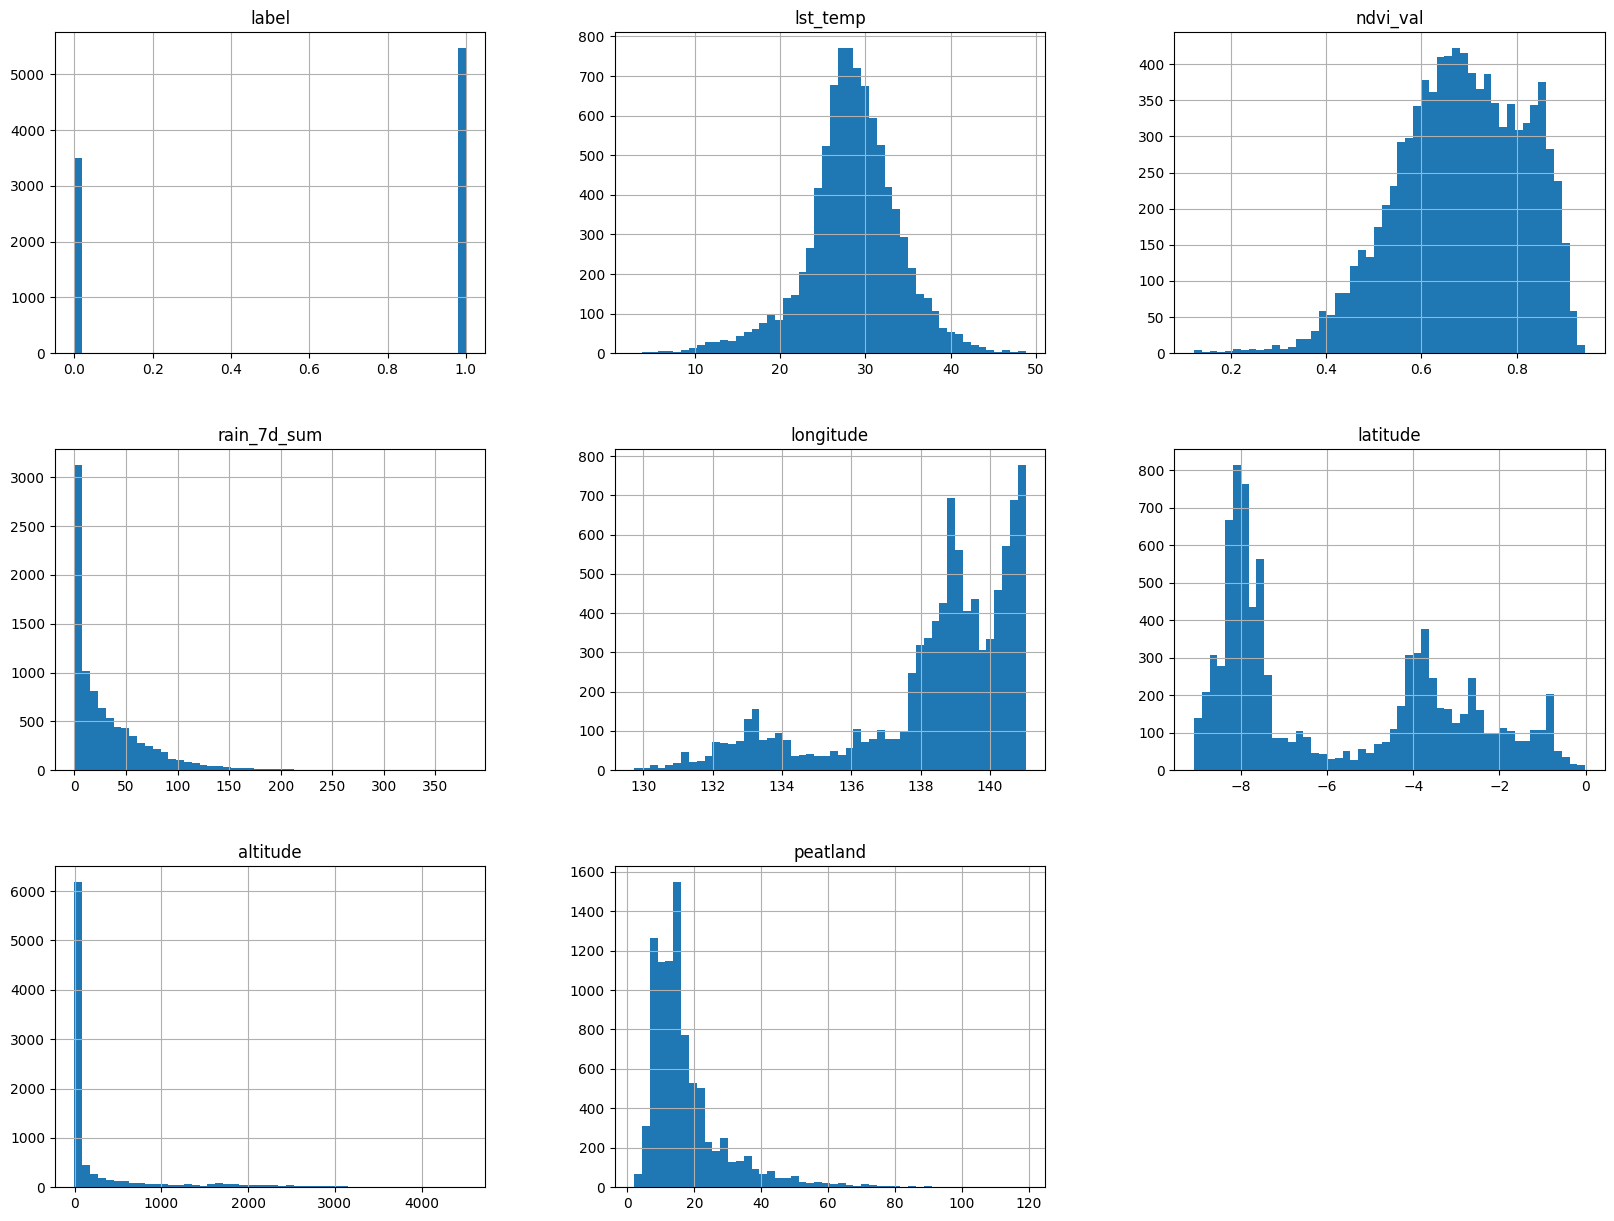

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
df_final.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
import numpy as np
from zlib import crc32

def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
df_final_with_id = df_final.copy()
df_final_with_id["id"] = df_final["longitude"] * 1000 + df_final["latitude"]

df_fire = df_final_with_id[df_final_with_id["label"] == 1]
df_nonfire = df_final_with_id[df_final_with_id["label"] == 0]

train_fire, test_fire = split_train_test_by_id(df_fire, 0.2, "id")
train_nonfire, test_nonfire = split_train_test_by_id(df_nonfire, 0.2, "id")

train_set = pd.concat([train_fire, train_nonfire])
test_set = pd.concat([test_fire, test_nonfire])

train_set = train_set.sample(frac=1, random_state=24).reset_index(drop=True)
test_set = test_set.sample(frac=1, random_state=24).reset_index(drop=True)

print(f"Total Train: {len(train_set)}")
print(f"Total Test: {len(test_set)}")

print("\nProporsi Train:")
print(train_set["label"].value_counts(normalize=True))

print("\nProporsi Test:")
print(test_set["label"].value_counts(normalize=True))

Total Train: 7237
Total Test: 1743

Proporsi Train:
label
1    0.611994
0    0.388006
Name: proportion, dtype: float64

Proporsi Test:
label
1    0.602983
0    0.397017
Name: proportion, dtype: float64


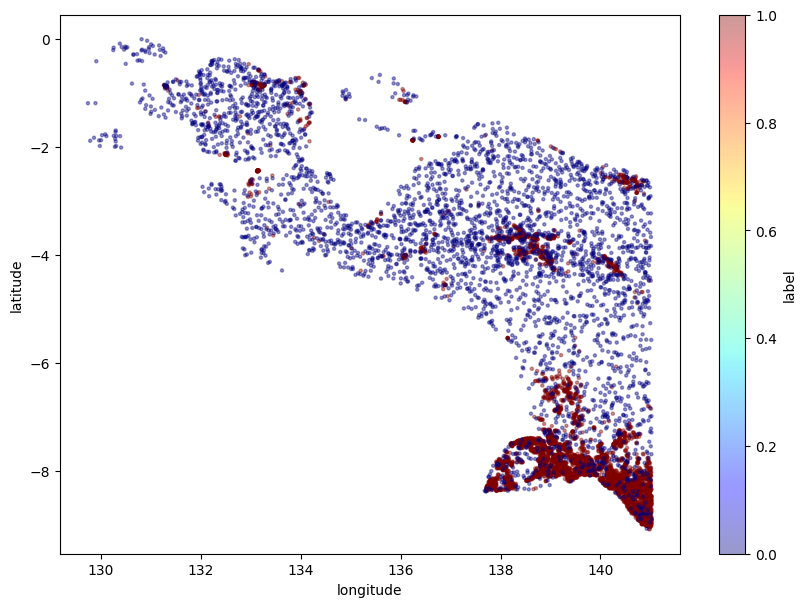

In [ ]:
df_final.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
              s=5, c='label', figsize=(10,7), cmap=plt.get_cmap('jet'), colorbar=True)
plt.show()

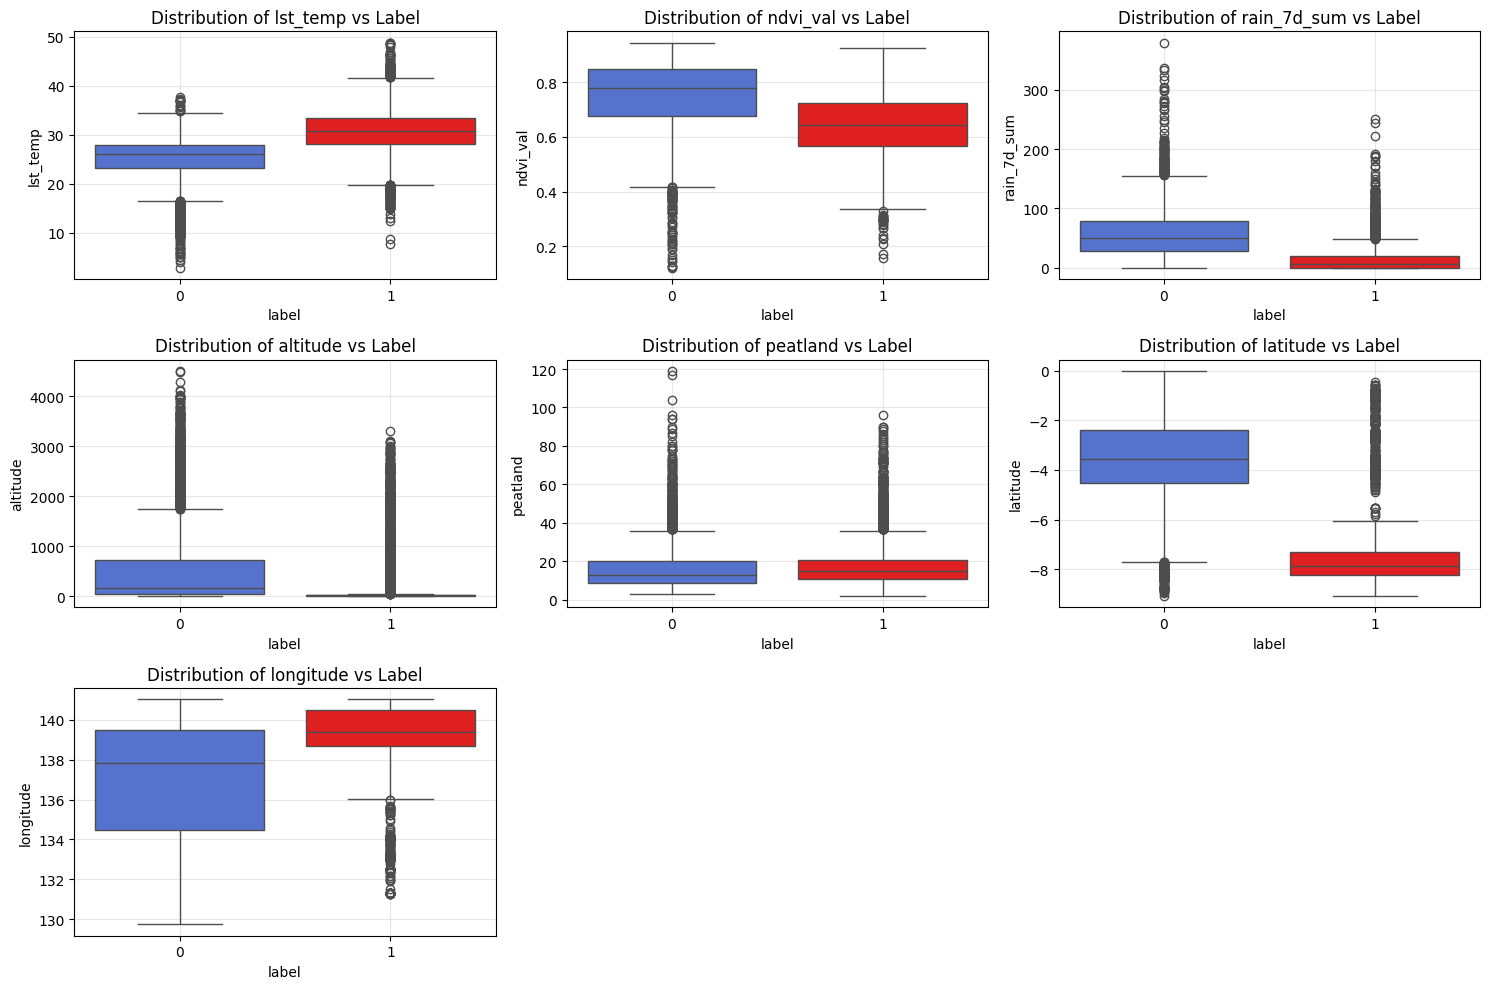

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Features needed to be checked, this is for visualization only
features_to_check = ['lst_temp', 'ndvi_val', 'rain_7d_sum', 'altitude', 'peatland', 'latitude', 'longitude']

plt.figure(figsize=(15, 10))

for i, col in enumerate(features_to_check):
    plt.subplot(3, 3, i+1) # Create small plots

    sns.boxplot(x='label', y=col, hue='label', data=df_final, palette={0: 'royalblue', 1: 'red'}, legend=False)

    plt.title(f'Distribution of {col} vs Label')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

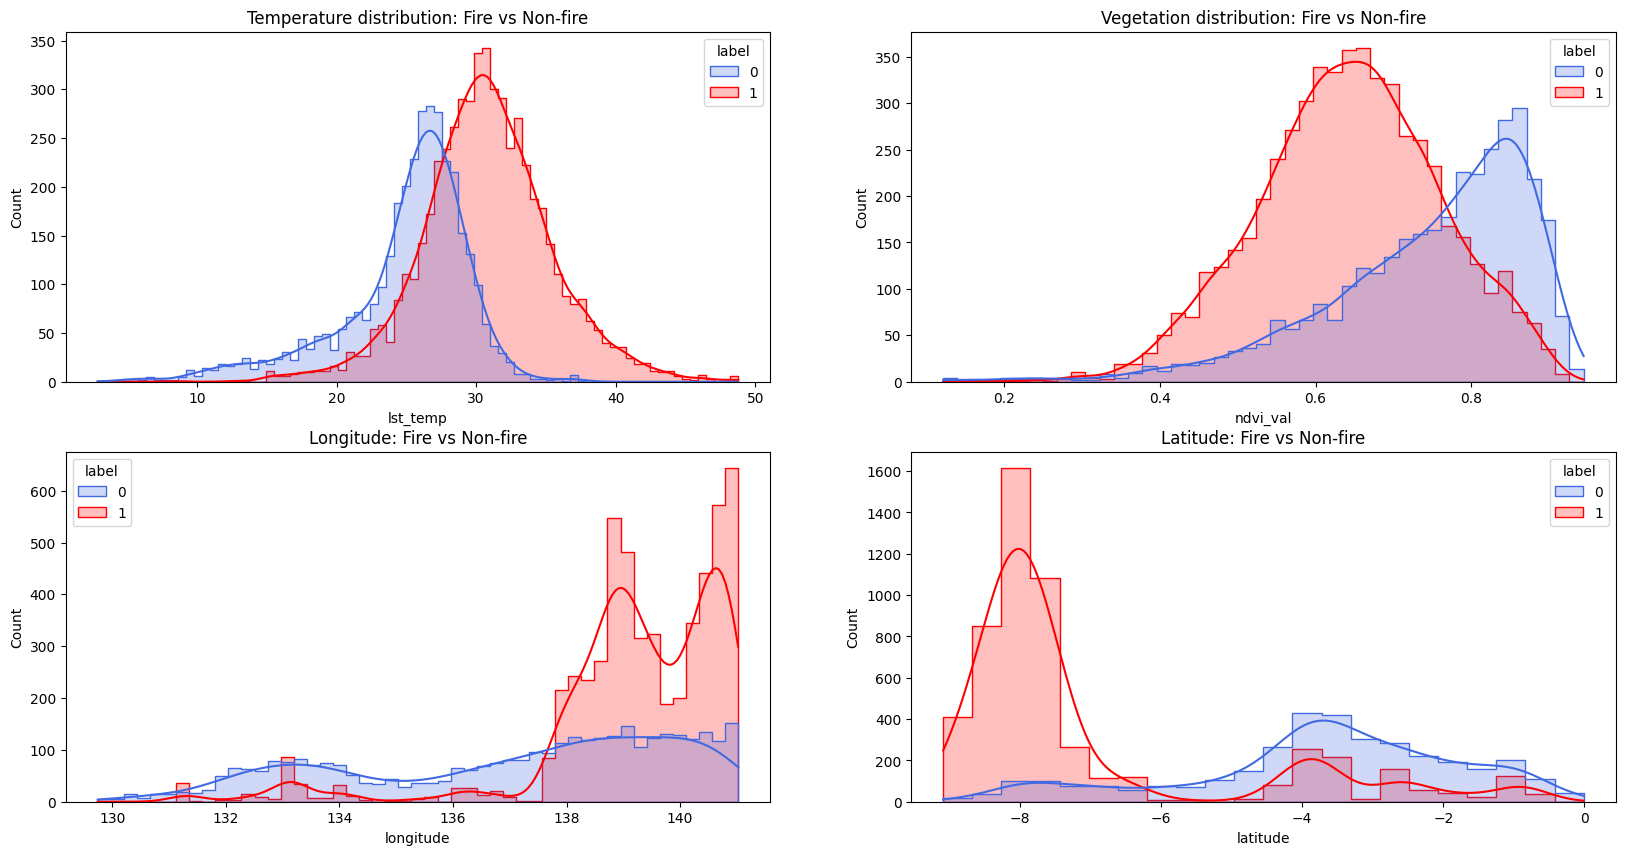

In [ ]:
plt.figure(figsize=(20, 10))

# LST Visualization on label "0" vs "1"
plt.subplot(2, 2, 1)
sns.histplot(data=df_final, x='lst_temp', hue='label', kde=True, element="step", palette={0:'royalblue', 1:'red'})
plt.title('Temperature distribution: Fire vs Non-fire')

# NDVI Visualization on label "0" vs "1"
plt.subplot(2, 2, 2)
sns.histplot(data=df_final, x='ndvi_val', hue='label', kde=True, element="step", palette={0:'royalblue', 1:'red'})
plt.title('Vegetation distribution: Fire vs Non-fire')

# Longitude Visualization on label "0" vs "1"
plt.subplot(2, 2, 3)
sns.histplot(data=df_final, x='longitude', hue='label', kde=True, element="step", palette={0:'royalblue', 1:'red'})
plt.title('Longitude: Fire vs Non-fire')

# Latitude Visualization on label "0" vs "1"
plt.subplot(2, 2, 4)
sns.histplot(data=df_final, x='latitude', hue='label', kde=True, element="step", palette={0:'royalblue', 1:'red'})
plt.title('Latitude: Fire vs Non-fire')

plt.show()

label          1.000000
lst_temp       0.520936
longitude      0.421501
peatland       0.045646
altitude      -0.280031
ndvi_val      -0.381101
rain_7d_sum   -0.551517
latitude      -0.627490
Name: label, dtype: float64


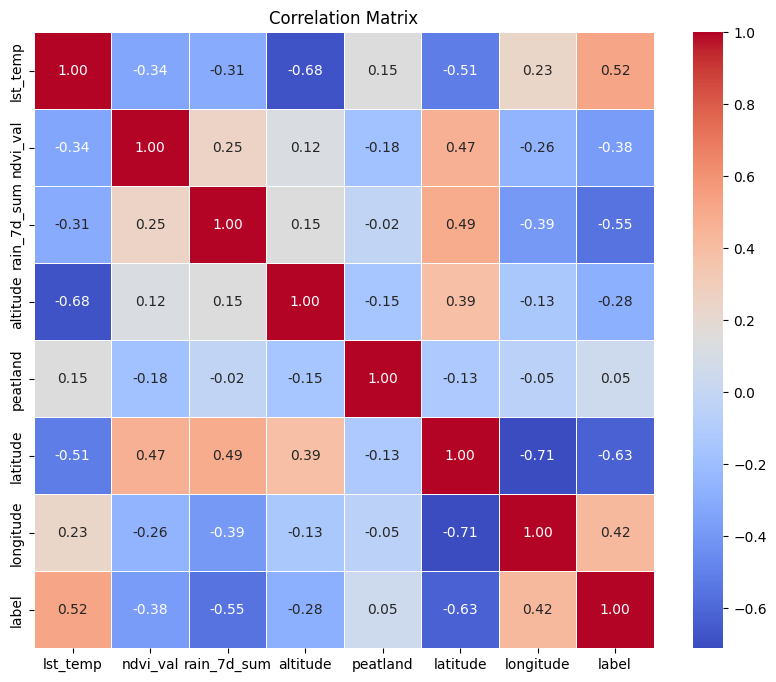

In [ ]:
plt.figure(figsize=(10, 8))

# Correlation matrix
correlation_matrix = df_final[features_to_check + ['label']].corr()
print(correlation_matrix['label'].sort_values(ascending=False))

# Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
wildfire_train = train_set.drop(["label", "peatland", "id"], axis=1)
wildfire_train_labels = train_set["label"].copy()

wildfire_test = test_set.drop(["label", "peatland", "id"], axis=1)
wildfire_test_labels = test_set["label"].copy()

In [ ]:
# There's no null values nothing to clean or making a transformation pipeline
# wildfire_train.dropna(subset=["..."])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

wildfire_train_scaled = scaler.fit_transform(wildfire_train)
wildfire_test_scaled = scaler.transform(wildfire_test)

wildfire_train_scaled = pd.DataFrame(wildfire_train_scaled, columns=wildfire_train.columns)
wildfire_test_scaled = pd.DataFrame(wildfire_test_scaled, columns=wildfire_test.columns)

print("Feature is ready to be trained:", wildfire_train_scaled.columns.tolist())
print("\nScaled data example:")
print(wildfire_train_scaled.head())

Feature is ready to be trained: ['lst_temp', 'ndvi_val', 'rain_7d_sum', 'longitude', 'latitude', 'altitude']

Scaled data example:
   lst_temp  ndvi_val  rain_7d_sum  longitude  latitude  altitude
0 -0.409081  1.192805     0.236633   0.014551  1.213590 -0.210608
1  1.390076 -0.438755    -0.263342   0.999875 -0.984268 -0.456574
2  0.876031 -0.121308    -0.340351   0.064841 -0.644240 -0.469152
3  0.523543 -0.130778    -0.822684   0.263036 -0.836807 -0.460767
4  1.665458 -2.026373    -0.822684   0.132982 -0.663324 -0.473345


Training the model
Training completed

Model accuracy: 93.34%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       692
           1       0.94      0.95      0.95      1051

    accuracy                           0.93      1743
   macro avg       0.93      0.93      0.93      1743
weighted avg       0.93      0.93      0.93      1743



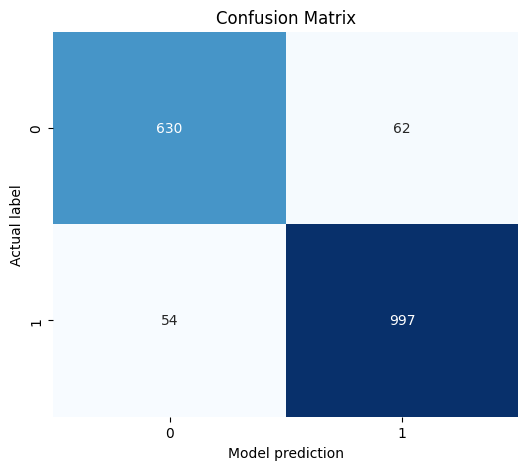

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Model initialization
# n_estimators=100, a good first attempt
rf_model = RandomForestClassifier(n_estimators=100, random_state=24)

# Training
print("Training the model")
rf_model.fit(wildfire_train_scaled, wildfire_train_labels)
print("Training completed")

# Prediction
y_pred = rf_model.predict(wildfire_test_scaled)

# Evaluate section

# Accuracy
acc = accuracy_score(wildfire_test_labels, y_pred)
print(f"\nModel accuracy: {acc:.2%}")

# B. Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(wildfire_test_labels, y_pred))

# C. Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(wildfire_test_labels, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Model prediction')
plt.ylabel('Actual label')
plt.title('Confusion Matrix')
plt.show()

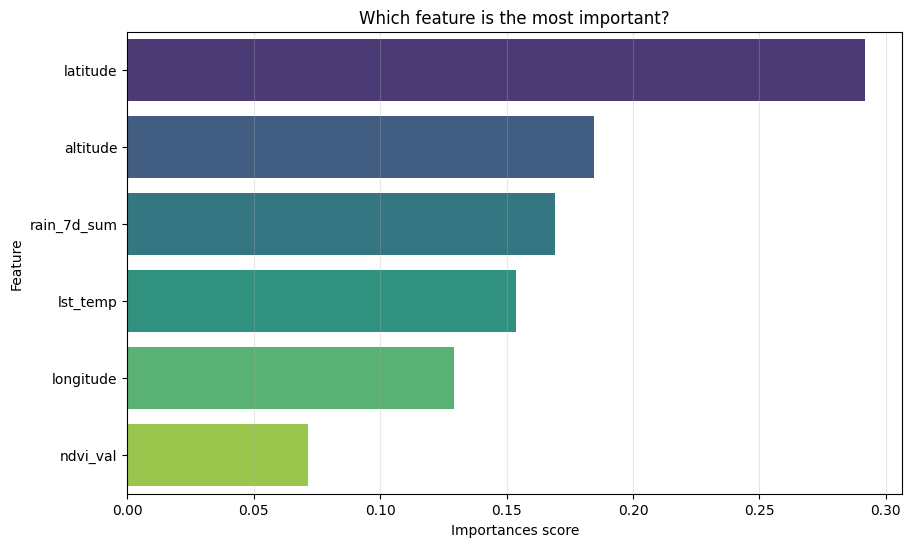

       Feature  Importance
4     latitude    0.291873
5     altitude    0.184685
2  rain_7d_sum    0.169227
0     lst_temp    0.153752
3    longitude    0.129043
1     ndvi_val    0.071421


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# See which feature importances
importances = rf_model.feature_importances_

# Take feature columns
feature_names = wildfire_train.columns

feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Show the feature importances
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

# Bar visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feature_imp_df, palette='viridis', legend=False)

plt.title('Which feature is the most important?')
plt.xlabel('Importances score')
plt.ylabel('Feature')
plt.grid(True, axis='x', alpha=0.3)
plt.show()

# Show the real value
print(feature_imp_df)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, wildfire_train_scaled, wildfire_train_labels,
                         scoring="accuracy", cv=10)

print(f"Scores: {scores}")
print(f"Mean: {scores.mean()}")
print(f"Standard Deviation: {scores.std()}")

Scores: [0.91436464 0.90331492 0.9198895  0.91574586 0.92679558 0.90883978
 0.90745856 0.92254495 0.93499308 0.90871369]
Mean: 0.9162660568686336
Standard Deviation: 0.009356837351857153


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print("Finding the best hyperparameter")
random_search.fit(wildfire_train_scaled, wildfire_train_labels)

print("\nBest hyperparameter:", random_search.best_params_)
print("Best score:", random_search.best_score_)

final_model = random_search.best_estimator_

Finding the best hyperparameter
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best hyperparameter: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': False}
Best score: 0.9166796801918238


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

final_predictions = final_model.predict(wildfire_test_scaled)

final_accuracy = accuracy_score(wildfire_test_labels, final_predictions)

print("Best Hyperparameters:", random_search.best_params_)
print(f"Validation Score (Training set): {random_search.best_score_:.2%}")
print(f"Test Score: {final_accuracy:.2%}")


Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': False}
Validation Score (Training set): 91.67%
Test Score: 92.77%


In [ ]:
from sklearn.metrics import classification_report
rf_recall = RandomForestClassifier(random_state=24)

param_dist_recall = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': [{0:1, 1:5}]
}

random_search_recall = RandomizedSearchCV(
    estimator=rf_recall,
    param_distributions=param_dist_recall,
    n_iter=30,
    cv=5,
    scoring='recall', # Finding the best recall model
    random_state=24,
    n_jobs=-1,
    verbose=1
)

print("Finding the model with highest recall")
random_search_recall.fit(wildfire_train_scaled, wildfire_train_labels)

best_rf_recall = random_search_recall.best_estimator_
y_pred_recall = best_rf_recall.predict(wildfire_test_scaled)

print("\nHigh-recall classification report:")
print(classification_report(wildfire_test_labels, y_pred_recall))
print("Best Hyperparameters:", random_search_recall.best_params_)

Finding the model with highest recall
Fitting 5 folds for each of 30 candidates, totalling 150 fits

High-recall classification report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       692
           1       0.90      0.97      0.94      1051

    accuracy                           0.92      1743
   macro avg       0.93      0.90      0.91      1743
weighted avg       0.92      0.92      0.92      1743

Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10, 'class_weight': {0: 1, 1: 5}, 'bootstrap': False}


In [ ]:
import joblib

filename = "papua_wildfire_model_v1.pkl"
filename_recall = "high_recall_model_v1.pkl"

joblib.dump(rf_model, filename)
print(f"Model saved on {filename}")
joblib.dump(best_rf_recall, filename_recall)
print(f"Model saved on {filename_recall}")

# Load
# loaded_model = joblib.load(filename)
# new_prediction = loaded_model.predict(...newdata...)

Model saved on papua_wildfire_model_v1.pkl
Model saved on high_recall_model_v1.pkl


In [ ]:
from xgboost import XGBClassifier

# xgb_model = XGBClassifier(scale_pos_weight=5, random_state=24)
xgb_model = XGBClassifier(objective='binary:logistic', random_state=24, n_jobs=1)

param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [0.66, 1]
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=30,
    cv=5,
    scoring='recall',
    random_state=24,
    n_jobs=-1,
    verbose=1,
)

random_search_xgb.fit(wildfire_train_scaled, wildfire_train_labels)
best_xgb_model = random_search_xgb.best_estimator_

y_pred_xgb = best_xgb_model.predict(wildfire_test_scaled)

print(classification_report(wildfire_test_labels, y_pred_xgb))
print("Best Parameters: ", random_search_xgb.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       692
           1       0.93      0.95      0.94      1051

    accuracy                           0.93      1743
   macro avg       0.93      0.92      0.93      1743
weighted avg       0.93      0.93      0.93      1743

Best Parameters:  {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
